In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 



#defining the four dirrections for later use
class Direction:
    RIGHT, TOP, LEFT, BOTTOM = range(4)




#Initializes instances of the Ising class with 
#parameters L (lattice size), J (coupling constant), 
#and T (temperature).

class Ising(object):

    def __init__(self, L, J, T):
        self.L = L
        self.N = L*L
        self.TWOJ = 2.*J
        self.T = T
        self.b = 1./T

        # initialize site poitions
        self.nn = np.zeros(shape=(self.N,4), dtype=np.int16)
        self.position = np.zeros(shape=(L,L), dtype=np.int16)
        self.x = np.zeros(self.N, dtype=np.int16)
        self.y = np.zeros(self.N, dtype=np.int16)

        # set up positions 
        # start with position zero
        n = 0 
        for iy in range(L):
            for ix in range(L):
                self.position[iy,ix] = n
                self.x[n] = ix
                self.y[n] = iy 
                self.nn[n,Direction.LEFT] = n - 1
                self.nn[n,Direction.RIGHT] = n + 1
                self.nn[n,Direction.TOP] = n + L
                self.nn[n,Direction.BOTTOM] = n - L
                if ix == 0:
                    self.nn[n,Direction.LEFT] = n + L - 1
                if ix == L-1:
                    self.nn[n,Direction.RIGHT] = n - (L - 1)
                if iy == 0:
                    self.nn[n,Direction.BOTTOM] = n + (L-1)*L
                if iy == L-1:
                    self.nn[n,Direction.TOP] = n - (L-1)*L
                n += 1

        #intialize spins
        r = np.random.random(self.N)*2 - 1
        self.spin = np.ones(self.N, dtype=np.int16)
        for i in range(self.N):
            if r[i] < 0:
                self.spin[i] *= -1
                
        # magnetization
        self.Mtot = np.sum(self.spin) 
        self.E = 0
        for i in range(self.N):
            self.E += -J*self.spin[i]*(self.spin[self.nn[i,Direction.RIGHT]] + self.spin[self.nn[i,Direction.TOP]])

        #transition probabilities 
        self.de = np.zeros(shape=(3,9))
        self.w = np.zeros(shape=(3,9))
        self.set_t(self.T)

    def set_t(self, T):
        self.T = T
        self.b = 1./T

        # lookup table for transition probabilities
        for spin_sum in range(-4,5):
            self.de[0,spin_sum+4] = -self.TWOJ*spin_sum
            self.de[2,spin_sum+4] = self.TWOJ*spin_sum
            p = np.exp(-self.b*self.de[0,spin_sum+4])
            self.w[0, spin_sum+4] = min(p, 1.)
            self.w[2, spin_sum+4] = min(1./p, 1.)
       #metropolis simulation 
    def metropolis(self):
        nchanges = 0
        for n in range(self.N):

            #picking  a random spin to flip
            i = int(np.random.random()*self.N)

            # change in energy
            iright = self.nn[i, Direction.RIGHT]
            ileft = self.nn[i, Direction.LEFT]
            itop = self.nn[i, Direction.TOP]
            ibottom = self.nn[i, Direction.BOTTOM]

            spin_sum = self.spin[iright] + self.spin[ileft] + self.spin[itop] + self.spin[ibottom]

            s = self.spin[i]
            deltaE = self.de[s+1, spin_sum+4]

            # accept if lowers energy or random num is below w
            if deltaE <= 0. or np.random.random() < self.w[s+1,spin_sum+4]:
                self.spin[i] *= -1
                self.Mtot += 2*(-s)
                self.E += deltaE
                nchanges += 1

        return nchanges
 
    
#setting up the system
L = 50
N = L**2
Nsteps = 1000
Ndecorr = 10
Temp = 2.27
J = 1

S = Ising(L, J, Temp)
E = np.zeros(Nsteps)
M = np.zeros(Nsteps)


frames = []

print("Starting Metropolis Algorithm...")

for i in range(Nsteps):
    # Run Metropolis algorithm Ndecorr times
    for n in range(Ndecorr):
        S.metropolis()
        
    # Append the current spin configuration to frames
    frames.append(np.copy(S.spin.reshape(L, L)))
    
    # Collect data for energy and magnetization
    E[i] = S.E
    M[i] = abs(S.Mtot)
    
print("Metropolis Algorithm finished.")

Starting Metropolis Algorithm...


KeyboardInterrupt: 

T =  2.27
<E>/N -146.312
<E^2>/N 22107.616
<M>/N 74.068
<M^2>/N 5964.6
C =  4933.973568281938
chi =  210.8067735682823
Acceptance ratio =  0.181846


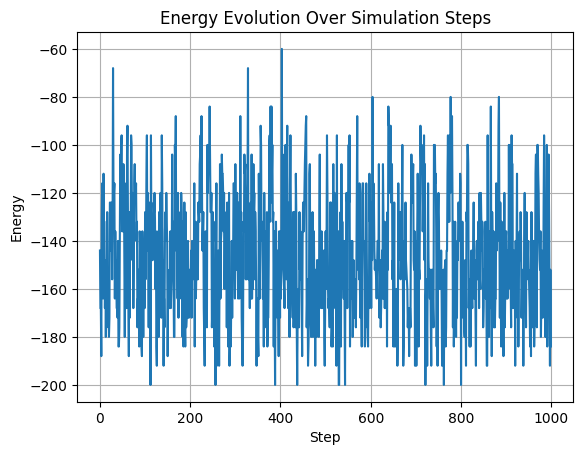

In [ ]:
#thermo analyis
"""Emu: Average energy per spin.
E2mu: Average squared energy per spin.
Mmu: Average magnetization per spin.
M2mu: Average squared magnetization per spin."""

naccept = 0
for i in range(Nsteps):
    for n in range(Ndecorr):
        naccept += S.metropolis()

Emu = np.sum(E)/Nsteps
E2mu = np.sum(E**2)/Nsteps
Mmu = np.sum(M)/Nsteps
M2mu = np.sum(M**2)/Nsteps

print('T = ', Temp)
print('<E>/N', Emu)
print('<E^2>/N', E2mu)
print('<M>/N', Mmu)
print('<M^2>/N', M2mu)
print('C = ', (E2mu - Emu*2)/(Temp*2))
print('chi = ', (M2mu - Mmu**2)/(Temp))
print("Acceptance ratio = ", naccept/(Nsteps*S.N*Ndecorr))

#plot of energy evolution
plt.plot(np.arange(0, Nsteps, 1), E)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.title('Energy Evolution Over Simulation Steps')
plt.grid(True)
plt.show()

# Calculate errors
ErrorE = np.sqrt((E2mu - Emu**2)/Nsteps)
ErrorM = np.sqrt((M2mu - Mmu**2) / Nsteps)

In [ ]:
import cv2

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('animation.mp4', fourcc, 30.0, (L, L))

# Iterate through frames and write them to the video
for frame in frames:
    # Convert frame to uint8 format (required by OpenCV)
    frame_uint8 = (frame * 255).astype(np.uint8)
    # Create yellow-purple color mapping
    frame_colored = cv2.applyColorMap(frame_uint8, cv2.COLORMAP_PARULA)
    # Write frame to video
    out.write(frame_colored)

# Release the VideoWriter object
out.release()

print("Video saved as animation.mp4")


Video saved as animation.mp4
